# Demo: 3D scene reconstruction (point cloud) from static images

Course: NICF- Spatial Reasoning from Sensor Data (SF)

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor-data/artificial-intelligence

Contact: Dr. Tian Jing

Email: tianjing@nus.edu.sg

## Objective

- Perform 3D scene reconstruction (point cloud) from static images

## Installation guideline

- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `srsdv` or install additional packages in your own environment

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow=1.10.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 notebook=5.7.4`

- Activate the environment `srsdv`

`conda activate srsdv`

- Browse to the folder that contains the workshop files, then run `Jupyter Notebook`

`jupyter notebook`


## Reference

- Chapter 4, 3D scene reconstruction using structure from motion, M. Beyeler (2015). OpenCV with Python Blueprints: Design and develop advanced computer vision projects using OpenCV with Python, Packt Publishing,  https://github.com/mbeyeler/opencv-python-blueprints/tree/master/chapter4

- Dataset: SfM Camera trajectory quality evaluation, https://github.com/openMVG/SfM_quality_evaluation



In [1]:
# functions

import cv2
import numpy as np
import sys

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

class SceneReconstruction3D:
    """3D scene reconstruction

        This class implements an algorithm for 3D scene reconstruction using
        stereo vision and structure-from-motion techniques.

        A 3D scene is reconstructed from a pair of images that show the same
        real-world scene from two different viewpoints. Feature matching is
        performed either with rich feature descriptors or based on optic flow.
        3D coordinates are obtained via triangulation.

        Note that a complete structure-from-motion pipeline typically includes
        bundle adjustment and geometry fitting, which are out of scope for
        this project.
    """
    def __init__(self, K):
        """Constructor
            This method initializes the scene reconstruction algorithm.
            :param K: 3x3 intrinsic camera matrix
        """
        self.K = K
        self.K_inv = np.linalg.inv(K)  # store inverse for fast access
        self.d = np.array([0.0, 0.0, 0.0, 0.0, 0.0]).reshape(1, 5)

    def load_image_pair(self, img_path1, img_path2, use_pyr_down=True):
        """Loads pair of images

            This method loads the two images for which the 3D scene should be
            reconstructed. The two images should show the same real-world scene
            from two different viewpoints.

            :param img_path1: path to first image
            :param img_path2: path to second image
            :param use_pyr_down: flag whether to downscale the images to
                                 roughly 600px width (True) or not (False)
        """
        self.img1 = cv2.imread(img_path1, cv2.CV_8UC3)
        self.img2 = cv2.imread(img_path2, cv2.CV_8UC3)

        # make sure images are valid
        if self.img1 is None:
            sys.exit("Image " + img_path1 + " could not be loaded.")
        if self.img2 is None:
            sys.exit("Image " + img_path2 + " could not be loaded.")

        if len(self.img1.shape) == 2:
            self.img1 = cv2.cvtColor(self.img1, cv2.COLOR_GRAY2BGR)
            self.img2 = cv2.cvtColor(self.img2, cv2.COLOR_GRAY2BGR)

        # scale down image if necessary
        # to something close to 600px wide
        target_width = 600
        if use_pyr_down and self.img1.shape[1] > target_width:
            while self.img1.shape[1] > 2*target_width:
                self.img1 = cv2.pyrDown(self.img1)
                self.img2 = cv2.pyrDown(self.img2)

        # undistort the images
        self.img1 = cv2.undistort(self.img1, self.K, self.d)
        self.img2 = cv2.undistort(self.img2, self.K, self.d)

    def plot_optic_flow(self):
        """Plots optic flow field

            This method plots the optic flow between the first and second
            image.
        """
        self._extract_keypoints("flow")

        img = self.img1
        for i in xrange(len(self.match_pts1)):
            cv2.line(img, tuple(self.match_pts1[i]), tuple(self.match_pts2[i]),
                     color=(255, 0, 0))
            theta = np.arctan2(self.match_pts2[i][1] - self.match_pts1[i][1],
                               self.match_pts2[i][0] - self.match_pts1[i][0])
            cv2.line(img, tuple(self.match_pts2[i]),
                     (np.int(self.match_pts2[i][0] - 6*np.cos(theta+np.pi/4)),
                      np.int(self.match_pts2[i][1] - 6*np.sin(theta+np.pi/4))),
                     color=(255, 0, 0))
            cv2.line(img, tuple(self.match_pts2[i]),
                     (np.int(self.match_pts2[i][0] - 6*np.cos(theta-np.pi/4)),
                      np.int(self.match_pts2[i][1] - 6*np.sin(theta-np.pi/4))),
                     color=(255, 0, 0))

        cv2.imshow("imgFlow", img)
        cv2.waitKey()

    def draw_epipolar_lines(self, feat_mode="SURF"):
        """Draws epipolar lines

            This method computes and draws the epipolar lines of the two
            loaded images.

            :param feat_mode: whether to use rich descriptors for feature
                              matching ("surf") or optic flow ("flow")
        """
        self._extract_keypoints(feat_mode)
        self._find_fundamental_matrix()
        # Find epilines corresponding to points in right image (second image)
        # and drawing its lines on left image
        pts2re = self.match_pts2.reshape(-1, 1, 2)
        lines1 = cv2.computeCorrespondEpilines(pts2re, 2, self.F)
        lines1 = lines1.reshape(-1, 3)
        img3, img4 = self._draw_epipolar_lines_helper(self.img1, self.img2,
                                                      lines1, self.match_pts1,
                                                      self.match_pts2)

        # Find epilines corresponding to points in left image (first image) and
        # drawing its lines on right image
        pts1re = self.match_pts1.reshape(-1, 1, 2)
        lines2 = cv2.computeCorrespondEpilines(pts1re, 1, self.F)
        lines2 = lines2.reshape(-1, 3)
        img1, img2 = self._draw_epipolar_lines_helper(self.img2, self.img1,
                                                      lines2, self.match_pts2,
                                                      self.match_pts1)

        cv2.imshow("left", img1)
        cv2.imshow("right", img3)
        cv2.waitKey(0)

    def plot_rectified_images(self, feat_mode="SURF"):
        """Plots rectified images

            This method computes and plots a rectified version of the two
            images side by side.

            :param feat_mode: whether to use rich descriptors for feature
                              matching ("surf") or optic flow ("flow")
        """
        self._extract_keypoints(feat_mode)
        self._find_fundamental_matrix()
        self._find_essential_matrix()
        self._find_camera_matrices_rt()

        R = self.Rt2[:, :3]
        T = self.Rt2[:, 3]
        #perform the rectification
        R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(self.K, self.d,
                                                          self.K, self.d,
                                                          self.img1.shape[:2],
                                                          R, T, alpha=1.0)
        mapx1, mapy1 = cv2.initUndistortRectifyMap(self.K, self.d, R1, self.K,
                                                   self.img1.shape[:2],
                                                   cv2.CV_32F)
        mapx2, mapy2 = cv2.initUndistortRectifyMap(self.K, self.d, R2, self.K,
                                                   self.img2.shape[:2],
                                                   cv2.CV_32F)
        img_rect1 = cv2.remap(self.img1, mapx1, mapy1, cv2.INTER_LINEAR)
        img_rect2 = cv2.remap(self.img2, mapx2, mapy2, cv2.INTER_LINEAR)

        # draw the images side by side
        total_size = (max(img_rect1.shape[0], img_rect2.shape[0]),
                      img_rect1.shape[1] + img_rect2.shape[1], 3)
        img = np.zeros(total_size, dtype=np.uint8)
        img[:img_rect1.shape[0], :img_rect1.shape[1]] = img_rect1
        img[:img_rect2.shape[0], img_rect1.shape[1]:] = img_rect2

        # draw horizontal lines every 25 px accross the side by side image
        for i in range(20, img.shape[0], 25):
            cv2.line(img, (0, i), (img.shape[1], i), (255, 0, 0))

        cv2.imshow('imgRectified', img)
        cv2.waitKey()

    def plot_point_cloud(self, feat_mode="SURF"):
        """Plots 3D point cloud

            This method generates and plots a 3D point cloud of the recovered
            3D scene.

            :param feat_mode: whether to use rich descriptors for feature
                              matching ("surf") or optic flow ("flow")
        """
        self._extract_keypoints(feat_mode)
        self._find_fundamental_matrix()
        self._find_essential_matrix()
        self._find_camera_matrices_rt()

        # triangulate points
        first_inliers = np.array(self.match_inliers1).reshape(-1, 3)[:, :2]
        second_inliers = np.array(self.match_inliers2).reshape(-1, 3)[:, :2]
        pts4D = cv2.triangulatePoints(self.Rt1, self.Rt2, first_inliers.T,
                                      second_inliers.T).T

        # convert from homogeneous coordinates to 3D
        pts3D = pts4D[:, :3]/np.repeat(pts4D[:, 3], 3).reshape(-1, 3)

        # plot with matplotlib
        Ys = pts3D[:, 0]
        Xs = pts3D[:, 1]
        Zs = pts3D[:, 2]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(Xs, Ys, Zs, c='r', marker='o')
        ax.set_xlabel('Y')
        ax.set_ylabel('X')
        ax.set_zlabel('Z')
        plt.title('3D point cloud')
        plt.show()

    def _extract_keypoints(self, feat_mode):
        """Extracts keypoints

            This method extracts keypoints for feature matching based on
            a specified mode:
            - "surf": use rich SURF descriptor
            - "flow": use optic flow

            :param feat_mode: keypoint extraction mode ("surf" or "flow")
        """
        # extract features
        if feat_mode.lower() == "surf":
            # feature matching via SURF and BFMatcher
            self._extract_keypoints_surf()
        else:
            if feat_mode.lower() == "flow":
                # feature matching via optic flow
                self._extract_keypoints_flow()
            else:
                sys.exit("Unknown feat_mode " + feat_mode +
                         ". Use 'SURF' or 'FLOW'")

    def _extract_keypoints_surf(self):
        """Extracts keypoints via SURF descriptors"""
        # extract keypoints and descriptors from both images
        detector = cv2.xfeatures2d.SURF_create(250)
        # detector = cv2.SURF(250)
        first_key_points, first_desc = detector.detectAndCompute(self.img1,None)
        second_key_points, second_desc = detector.detectAndCompute(self.img2,None)

        # match descriptors
        matcher = cv2.BFMatcher(cv2.NORM_L1, True)
        matches = matcher.match(first_desc, second_desc)

        # generate lists of point correspondences
        first_match_points = np.zeros((len(matches), 2), dtype=np.float32)
        second_match_points = np.zeros_like(first_match_points)
        for i in range(len(matches)):
            first_match_points[i] = first_key_points[matches[i].queryIdx].pt
            second_match_points[i] = second_key_points[matches[i].trainIdx].pt

        self.match_pts1 = first_match_points
        self.match_pts2 = second_match_points

    def _extract_keypoints_flow(self):
        """Extracts keypoints via optic flow"""
        # find FAST features
        fast = cv2.FastFeatureDetector()
        first_key_points = fast.detect(self.img1, None)

        first_key_list = [i.pt for i in first_key_points]
        first_key_arr = np.array(first_key_list).astype(np.float32)

        second_key_arr, status, err = cv2.calcOpticalFlowPyrLK(self.img1,
                                                               self.img2,
                                                               first_key_arr)

        # filter out the points with high error
        # keep only entries with status=1 and small error
        condition = (status == 1) * (err < 5.)
        concat = np.concatenate((condition, condition), axis=1)
        first_match_points = first_key_arr[concat].reshape(-1, 2)
        second_match_points = second_key_arr[concat].reshape(-1, 2)

        self.match_pts1 = first_match_points
        self.match_pts2 = second_match_points

    def _find_fundamental_matrix(self):
        """Estimates fundamental matrix """
        self.F, self.Fmask = cv2.findFundamentalMat(self.match_pts1,
                                                    self.match_pts2,
                                                    cv2.FM_RANSAC, 0.1, 0.99)

    def _find_essential_matrix(self):
        """Estimates essential matrix based on fundamental matrix """
        self.E = self.K.T.dot(self.F).dot(self.K)

    def _find_camera_matrices_rt(self):
        """Finds the [R|t] camera matrix"""
        # decompose essential matrix into R, t (See Hartley and Zisserman 9.13)
        U, S, Vt = np.linalg.svd(self.E)
        W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
                      1.0]).reshape(3, 3)

        # iterate over all point correspondences used in the estimation of the
        # fundamental matrix
        first_inliers = []
        second_inliers = []
        for i in range(len(self.Fmask)):
            if self.Fmask[i]:
                # normalize and homogenize the image coordinates
                first_inliers.append(self.K_inv.dot([self.match_pts1[i][0],
                                     self.match_pts1[i][1], 1.0]))
                second_inliers.append(self.K_inv.dot([self.match_pts2[i][0],
                                      self.match_pts2[i][1], 1.0]))

        # Determine the correct choice of second camera matrix
        # only in one of the four configurations will all the points be in
        # front of both cameras
        # First choice: R = U * Wt * Vt, T = +u_3 (See Hartley Zisserman 9.19)
        R = U.dot(W).dot(Vt)
        T = U[:, 2]
        if not self._in_front_of_both_cameras(first_inliers, second_inliers,
                                              R, T):
            # Second choice: R = U * W * Vt, T = -u_3
            T = - U[:, 2]

        if not self._in_front_of_both_cameras(first_inliers, second_inliers,
                                              R, T):
            # Third choice: R = U * Wt * Vt, T = u_3
            R = U.dot(W.T).dot(Vt)
            T = U[:, 2]

            if not self._in_front_of_both_cameras(first_inliers,
                                                  second_inliers, R, T):
                # Fourth choice: R = U * Wt * Vt, T = -u_3
                T = - U[:, 2]

        self.match_inliers1 = first_inliers
        self.match_inliers2 = second_inliers
        self.Rt1 = np.hstack((np.eye(3), np.zeros((3, 1))))
        self.Rt2 = np.hstack((R, T.reshape(3, 1)))

    def _draw_epipolar_lines_helper(self, img1, img2, lines, pts1, pts2):
        """Helper method to draw epipolar lines and features """
        if img1.shape[2] == 1:
            img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
        if img2.shape[2] == 1:
            img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

        c = img1.shape[1]
        for r, pt1, pt2 in zip(lines, pts1, pts2):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2]/r[1]])
            x1, y1 = map(int, [c, -(r[2] + r[0]*c) / r[1]])
            cv2.line(img1, (x0, y0), (x1, y1), color, 1)
            cv2.circle(img1, tuple(pt1), 5, color, -1)
            cv2.circle(img2, tuple(pt2), 5, color, -1)
        return img1, img2

    def _in_front_of_both_cameras(self, first_points, second_points, rot,
                                  trans):
        """Determines whether point correspondences are in front of both
           images"""
        rot_inv = rot
        for first, second in zip(first_points, second_points):
            first_z = np.dot(rot[0, :] - second[0]*rot[2, :],
                             trans) / np.dot(rot[0, :] - second[0]*rot[2, :],
                                             second)
            first_3d_point = np.array([first[0] * first_z,
                                       second[0] * first_z, first_z])
            second_3d_point = np.dot(rot.T, first_3d_point) - np.dot(rot.T,
                                                                     trans)

            if first_3d_point[2] < 0 or second_3d_point[2] < 0:
                return False

        return True

    def _linear_ls_triangulation(self, u1, P1, u2, P2):
        """Triangulation via Linear-LS method"""
        # build A matrix for homogeneous equation system Ax=0
        # assume X = (x,y,z,1) for Linear-LS method
        # which turns it into AX=B system, where A is 4x3, X is 3x1 & B is 4x1
        A = np.array([u1[0]*P1[2, 0] - P1[0, 0], u1[0]*P1[2, 1] - P1[0, 1],
                      u1[0]*P1[2, 2] - P1[0, 2], u1[1]*P1[2, 0] - P1[1, 0],
                      u1[1]*P1[2, 1] - P1[1, 1], u1[1]*P1[2, 2] - P1[1, 2],
                      u2[0]*P2[2, 0] - P2[0, 0], u2[0]*P2[2, 1] - P2[0, 1],
                      u2[0]*P2[2, 2] - P2[0, 2], u2[1]*P2[2, 0] - P2[1, 0],
                      u2[1]*P2[2, 1] - P2[1, 1],
                      u2[1]*P2[2, 2] - P2[1, 2]]).reshape(4, 3)

        B = np.array([-(u1[0]*P1[2, 3] - P1[0, 3]),
                      -(u1[1]*P1[2, 3] - P1[1, 3]),
                      -(u2[0]*P2[2, 3] - P2[0, 3]),
                      -(u2[1]*P2[2, 3] - P2[1, 3])]).reshape(4, 1)

        ret, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
        return X.reshape(1, 3)


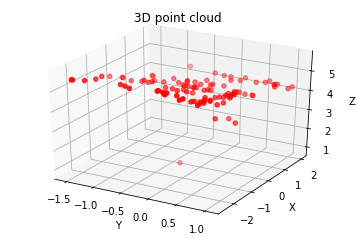

In [2]:
# camera intrinsic matrix is provided in ground truth
# SfM Camera trajectory quality evaluation, https://github.com/openMVG/SfM_quality_evaluation
K = np.array([[2759.48/4, 0, 1520.69/4, 0, 2764.16/4,
               1006.81/4, 0, 0, 1]]).reshape(3, 3)

scene = SceneReconstruction3D(K)

# load a pair of images for which to perform SfM
scene.load_image_pair("data/fountain/0004.png", "data/fountain/0005.png")

# draw 3D point cloud of fountain
scene.plot_point_cloud()



Have a nice day!